In [123]:
import random
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import seaborn as sns
import numpy as np
import pickle
from joblib import Parallel, delayed
from math import log2, ceil
# import ardent
# from scipy.ndimage import zoom
import time
import os
import pandas as pd

from proglearn.progressive_learner import ProgressiveLearner
from proglearn.deciders import SimpleArgmaxAverage
from proglearn.transformers import TreeClassificationTransformer, NeuralClassificationTransformer
from proglearn.voters import TreeClassificationVoter, KNNClassificationVoter
from proglearn.sims import generate_gaussian_parity

import pandas as pd
import SimpleITK as sitk
from sklearn.neighbors import BallTree
# from skimage.transform import rotate

In [2]:
context = sns.plotting_context(context="talk", font_scale=1)
sns.set_context(context)

In [3]:
def init_forest(max_depth):
    # np.random.seed(1)
    default_transformer_class = TreeClassificationTransformer
    default_transformer_kwargs = {"kwargs" : {"max_depth" : max_depth}}

    default_voter_class = TreeClassificationVoter
    default_voter_kwargs = {}

    default_decider_class = SimpleArgmaxAverage
    default_decider_kwargs = {"classes" : np.arange(2)}
    progressive_learner = ProgressiveLearner(default_transformer_class = default_transformer_class,
                                            default_transformer_kwargs = default_transformer_kwargs,
                                            default_voter_class = default_voter_class,
                                            default_voter_kwargs = default_voter_kwargs,
                                            default_decider_class = default_decider_class,
                                            default_decider_kwargs = default_decider_kwargs)
    uf = ProgressiveLearner(default_transformer_class = default_transformer_class,
                                            default_transformer_kwargs = default_transformer_kwargs,
                                            default_voter_class = default_voter_class,
                                            default_voter_kwargs = default_voter_kwargs,
                                            default_decider_class = default_decider_class,
                                            default_decider_kwargs = default_decider_kwargs)
    return progressive_learner, uf

In [4]:
def grid_to_pred(task_pos_reshaped, test_task, xx, yy):
    pred = np.empty((len(test_task), ))

    for i in range(len(test_task)):
        x_ind = np.where(test_task[i,0] <= xx[0,:])[0][0]
        y_ind = np.where(test_task[i,1] <= yy[:,0])[0][0]
        pred[i] = task_pos_reshaped[y_ind, x_ind]

    pred = pred.reshape((-1,1))
    pred = np.hstack((pred, 1-pred))
    pred = np.argmax(pred, axis=1)
    
    return pred

In [71]:
def to_grid_in_cir(test_task1, test_task2):
    h = 0.01
    x_min1, x_max1 = test_task1[:,0].min(), test_task1[:,0].max()
    y_min1, y_max1 = test_task1[:,1].min(), test_task1[:,1].max()
    x_min2, x_max2 = test_task2[:,0].min(), test_task2[:,0].max()
    y_min2, y_max2 = test_task2[:,1].min(), test_task2[:,1].max()

    x_min = min(x_min1, x_min2) - 0.1
    x_max = max(x_max1, x_max2) + 0.1
    y_min = min(y_min1, y_min2) - 0.1
    y_max = max(y_max1, y_max2) + 0.1
    x, y = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    r = np.sqrt(x**2 + y**2)  # centered at (0,0)
    inside = r <= 1  # radius of 1
    x_cir = x[inside]  # can also use np.ma.masked_less_equal(r,1).data
    y_cir = y[inside]
    return x, y, inside, np.array([x_cir, y_cir]).T

In [5]:
# def to_grid(test_task1, test_task2):
#     h = 0.01
#     x_min1, x_max1 = test_task1[:,0].min(), test_task1[:,0].max()
#     y_min1, y_max1 = test_task1[:,1].min(), test_task1[:,1].max()
#     x_min2, x_max2 = test_task2[:,0].min(), test_task2[:,0].max()
#     y_min2, y_max2 = test_task2[:,1].min(), test_task2[:,1].max()

#     x_min = min(x_min1, x_min2) - 0.1
#     x_max = max(x_max1, x_max2) + 0.1
#     y_min = min(y_min1, y_min2) - 0.1
#     y_max = max(y_max1, y_max2) + 0.1
#     xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
#     new_test_task = np.c_[xx.ravel(), yy.ravel()]
#     return xx, yy, new_test_task

In [16]:
def get_colors(colors, inds):
    c = [colors[i] for i in inds]
    return c

In [39]:
def box_to_cir(data):
    X = data[0]
    y = data[1]
    X_cir = []
    y_cir = []
    for i in range(len(X)):
        if (X[i,0]**2 + X[i,1]**2 <= 1):
            X_cir.append(X[i,:])
            y_cir.append(y[i])
    return np.array(X_cir).reshape(-1,2), np.array(y_cir).reshape(-1)

In [7]:
def generate_posteriors(X, task_id, forest, transformers):
    vote_per_transformer_id = []
    for transformer_id in transformers:
        vote_per_bag_id = []
        for bag_id in range(
            len(forest.task_id_to_decider[task_id].transformer_id_to_transformers_[transformer_id])
        ):
            transformer = forest.task_id_to_decider[task_id].transformer_id_to_transformers_[transformer_id][
                bag_id
            ]
            X_transformed = transformer.transform(X)
            voter = forest.task_id_to_decider[task_id].transformer_id_to_voters_[transformer_id][bag_id]
            vote = voter.predict_proba(X_transformed)
            vote_per_bag_id.append(vote)
        vote_per_transformer_id.append(np.mean(vote_per_bag_id, axis=0))

    return vote_per_transformer_id

In [8]:
def run_elastix(task1pred1_reshaped, task2pred2_reshaped, metric, ite):
    elastixImageFilter = sitk.ElastixImageFilter()
    elastixImageFilter.SetFixedImage(sitk.GetImageFromArray(task1pred1_reshaped))
    elastixImageFilter.SetMovingImage(sitk.GetImageFromArray(task2pred2_reshaped))
    ParamMap = sitk.GetDefaultParameterMap('affine')
#     ParamMap['AutomaticTransformInitialization'] = ['true']
#     ParamMap['AutomaticScalesEstimation'] = ['true']
#     ParamMap['AutomaticTransformInitializationMethod'] = ['GeometricalCenter']
#     ParamMap['Metric'] = [metric]
    
    ParamMap['AutomaticTransformInitialization'] = ['false']
    ParamMap['AutomaticTransformInitializationMethod'] = ['GeometricalCenter']
    ParamMap['Metric'] = [metric]
    ParamMap['MaximumNumberOfIterations'] = [ite]

    # Set the parameter map:
    elastixImageFilter.SetParameterMap(ParamMap)

    # Register the 2D images:
    elastixImageFilter.Execute()

    # Get the registered image:
    RegIm = sitk.GetArrayFromImage(elastixImageFilter.GetResultImage())
    params = elastixImageFilter.GetTransformParameterMap()[0]["TransformParameters"]
    
    return RegIm, params

In [9]:
def params_to_mat(params):
    init_affines = np.eye(3)
    init_affines[0,:2] = [float(params[0]), float(params[2])]
    init_affines[1,:2] = [float(params[1]), float(params[3])]
    init_affines[2,:2] = [float(params[4]), float(params[5])]
    return init_affines.T

In [10]:
# def exp(n_task1, n_task2, max_depth, n_test=1000, task1_angle=0, task2_angle=np.pi/4, n_trees=10):
#     #source data
#     X_task1, y_task1 = generate_gaussian_parity(n_task1, angle_params=task1_angle)
#     test_task1, test_label_task1 = generate_gaussian_parity(n_test, angle_params=task1_angle)
    
#     #target data
#     X_task2, y_task2 = generate_gaussian_parity(n_task2, angle_params=task2_angle)
#     test_task2, test_label_task2 = generate_gaussian_parity(n_test, angle_params=task2_angle)

#     xx2, yy2, test_task2_grid = to_grid(test_task1, test_task2)
#     errors = np.zeros(7, dtype=float)
    
#     l2f, uf = init_forest(max_depth)
#     l2f.add_task(X_task1, y_task1, num_transformers=n_trees)
#     l2f.add_task(X_task2, y_task2, num_transformers=n_trees)

#     l2f_task1 = generate_posteriors(test_task2_grid, 0, l2f, [0,1])
#     l2f_task2 = generate_posteriors(test_task2_grid, 1, l2f, [0,1])

#     task1pred1_reshaped = l2f_task1[0][:,0].reshape(xx2.shape)
#     task1pred2_reshaped = l2f_task1[1][:,0].reshape(xx2.shape)
#     task2pred1_reshaped = l2f_task2[0][:,0].reshape(xx2.shape)
#     task2pred2_reshaped = l2f_task2[1][:,0].reshape(xx2.shape)

#     vote1 = np.mean([task1pred1_reshaped, task1pred2_reshaped], axis=0)
#     errors[1] = 1 - np.mean(
#         grid_to_pred(vote1, test_task1, xx2, yy2) == test_label_task1
#     )  # l2f task1 error

# #     vote2 = np.mean([task2pred1_reshaped, task2pred2_reshaped], axis=0)
# #     errors[3] = 1 - np.mean(
# #         grid_to_pred(vote2, test_task2, xx2, yy2) == test_label_task2
# #     )  # l2f task2 error
    
#     # L2F o elastix task1 error
#     task1pred1_deformed, params = run_elastix(
#         task1pred1_reshaped, task2pred2_reshaped, 'AdvancedNormalizedCorrelation', '500'
#     )
#     vote3 = np.mean([task1pred1_reshaped, task1pred1_deformed], axis=0)
#     errors[4] = 1 - np.mean(
#         grid_to_pred(vote3, test_task1, xx2, yy2) == test_label_task1
#     )  

#     # UF
#     uf.add_task(X_task1, y_task1, num_transformers=2*n_trees)
#     uf.add_task(X_task2, y_task2, num_transformers=2*n_trees)

#     uf_task1 = generate_posteriors(test_task2_grid, 0, uf, [0])
#     uf_task2 = generate_posteriors(test_task2_grid, 1, uf, [0])

#     task1pred1_reshaped_uf = uf_task1[0][:,0].reshape(xx2.shape)
#     task2pred1_reshaped_uf = uf_task2[0][:,0].reshape(xx2.shape)

#     errors[0] = 1 - np.mean(
#         grid_to_pred(task1pred1_reshaped_uf, test_task1, xx2, yy2) == test_label_task1
#     )  # uf task1 error
# #     errors[2] = 1 - np.mean(
# #         grid_to_pred(task2pred1_reshaped_uf, test_task2, xx2, yy2) == test_label_task2
# #     )  # uf task2 error

#     return errors

In [102]:
def reshape_posteriors(inside, task):
    inside_ravel = inside.ravel()
    preds = np.zeros(inside_ravel.shape)
    j = 0
    for i in range(len(inside_ravel)):
        if inside_ravel[i]:
            preds[i] = task[j]
            j += 1
    preds = preds.reshape(inside.shape)
    
    return preds

### compute errors

In [192]:
def vote_to_pred(vote, test_task, test_grid):
    tree = BallTree(test_grid)
    pred = np.zeros(test_task.shape)
    for i in range(len(test_task)):
        _, ind = tree.query(test_task[i,:].reshape(-1,2), k=1)
        pred[i,0] = vote[ind]
        pred[i,1] = 1 - pred[i,0]
        
    return pred

In [234]:
# n_task1=100; n_task2=100; max_depth=7; n_test=1000; task1_angle=np.pi*(75/180); task2_angle=np.pi*(15/180); n_trees=10
def exp(n_task1, n_task2, max_depth, n_test=1000, task1_angle=0, task2_angle=np.pi/4, n_trees=10, ite=500):
    #source data
    X_task1, y_task1 = box_to_cir(generate_gaussian_parity(n_task1, angle_params=task1_angle))
    test_task1, test_label_task1 = box_to_cir(generate_gaussian_parity(n_test, angle_params=task1_angle))

    #target data
    X_task2, y_task2 = box_to_cir(generate_gaussian_parity(n_task2, angle_params=task2_angle))
    test_task2, test_label_task2 = box_to_cir(generate_gaussian_parity(n_test, angle_params=task2_angle))

    xx, yy, inside, test_grid = to_grid_in_cir(test_task1, test_task2)

    l2f, uf = init_forest(max_depth)
    l2f.add_task(X_task1, y_task1, num_transformers=n_trees)
    l2f.add_task(X_task2, y_task2, num_transformers=n_trees)

    l2f_task1 = generate_posteriors(test_grid, 0, l2f, [0,1])
    l2f_task2 = generate_posteriors(test_grid, 1, l2f, [0,1])

    task1pred1_reshaped = reshape_posteriors(inside, l2f_task1[0][:,0])
    task1pred2_reshaped = reshape_posteriors(inside, l2f_task1[1][:,0])
    task2pred1_reshaped = reshape_posteriors(inside, l2f_task2[0][:,0])
    task2pred2_reshaped = reshape_posteriors(inside, l2f_task2[1][:,0])

    uf.add_task(X_task1, y_task1, num_transformers=2*n_trees)
    uf.add_task(X_task2, y_task2, num_transformers=2*n_trees)

    uf_task1 = generate_posteriors(test_grid, 0, uf, [0])
    uf_task2 = generate_posteriors(test_grid, 1, uf, [0])

    task1pred1_reshaped_uf = reshape_posteriors(inside, uf_task1[0][:,0])
#     task2pred1_reshaped_uf = reshape_posteriors(inside, uf_task2[0][:,0])
    
    
    # run elastix
    task1pred1_deformed, params = run_elastix(
            task1pred1_reshaped, task2pred2_reshaped, 'AdvancedNormalizedCorrelation', str(ite)
        )
    
    errors = np.zeros(3, dtype=float)
    vote1 = np.mean([task1pred1_reshaped, task1pred2_reshaped], axis=0)[inside].ravel()
    pred1 = vote_to_pred(vote1, test_task1, test_grid)
    errors[0] = 1-np.mean(np.argmax(pred1, axis=1) == test_label_task1)

    vote2 = np.mean([task1pred1_reshaped, task1pred1_deformed], axis=0)[inside].ravel()
    pred2 = vote_to_pred(vote2, test_task1, test_grid)
    errors[1] = 1-np.mean(np.argmax(pred2, axis=1) == test_label_task1)

    vote3 = task1pred1_reshaped_uf[inside].ravel()
    pred3 = vote_to_pred(vote3, test_task1, test_grid)
    errors[2] = 1-np.mean(np.argmax(pred3, axis=1) == test_label_task1)
    
    return errors

In [224]:
#source data
X_task1, y_task1 = box_to_cir(generate_gaussian_parity(n_task1, angle_params=task1_angle))
test_task1, test_label_task1 = box_to_cir(generate_gaussian_parity(n_test, angle_params=task1_angle))

#target data
X_task2, y_task2 = box_to_cir(generate_gaussian_parity(n_task2, angle_params=task2_angle))
test_task2, test_label_task2 = box_to_cir(generate_gaussian_parity(n_test, angle_params=task2_angle))

xx, yy, inside, test_grid = to_grid_in_cir(test_task1, test_task2)

l2f, uf = init_forest(max_depth)
l2f.add_task(X_task1, y_task1, num_transformers=n_trees)
l2f.add_task(X_task2, y_task2, num_transformers=n_trees)

l2f_task1 = generate_posteriors(test_grid, 0, l2f, [0,1])
l2f_task2 = generate_posteriors(test_grid, 1, l2f, [0,1])

task1pred1_reshaped = reshape_posteriors(inside, l2f_task1[0][:,0])
task1pred2_reshaped = reshape_posteriors(inside, l2f_task1[1][:,0])
task2pred1_reshaped = reshape_posteriors(inside, l2f_task2[0][:,0])
task2pred2_reshaped = reshape_posteriors(inside, l2f_task2[1][:,0])

uf.add_task(X_task1, y_task1, num_transformers=2*n_trees)
uf.add_task(X_task2, y_task2, num_transformers=2*n_trees)

uf_task1 = generate_posteriors(test_grid, 0, uf, [0])
uf_task2 = generate_posteriors(test_grid, 1, uf, [0])

task1pred1_reshaped_uf = reshape_posteriors(inside, uf_task1[0][:,0])

errors = np.zeros(3, dtype=float)
vote1 = np.mean([task1pred1_reshaped, task1pred2_reshaped], axis=0)[inside].ravel()
pred1 = vote_to_pred(vote1, test_task1, test_grid)
errors[0] = 1-np.mean(np.argmax(pred1, axis=1) == test_label_task1)

vote3 = task1pred1_reshaped_uf[inside].ravel()
pred3 = vote_to_pred(vote3, test_task1, test_grid)
errors[2] = 1-np.mean(np.argmax(pred3, axis=1) == test_label_task1)

In [225]:
# run elastix
task1pred1_deformed, params = run_elastix(
        task1pred1_reshaped, task2pred2_reshaped, 'AdvancedNormalizedCorrelation', '1000'
    )
vote2 = np.mean([task1pred1_reshaped, task1pred1_deformed], axis=0)[inside].ravel()
pred2 = vote_to_pred(vote2, test_task1, test_grid)
errors[1] = 1-np.mean(np.argmax(pred2, axis=1) == test_label_task1)
errors

array([0.08649289, 0.07582938, 0.10545024])

In [226]:
# run elastix
task1pred1_deformed, params = run_elastix(
        task1pred1_reshaped, task2pred2_reshaped, 'AdvancedNormalizedCorrelation', '500'
    )
vote2 = np.mean([task1pred1_reshaped, task1pred1_deformed], axis=0)[inside].ravel()
pred2 = vote_to_pred(vote2, test_task1, test_grid)
errors[1] = 1-np.mean(np.argmax(pred2, axis=1) == test_label_task1)
errors

array([0.08649289, 0.07819905, 0.10545024])

In [227]:
# run elastix
task1pred1_deformed, params = run_elastix(
        task1pred1_reshaped, task2pred2_reshaped, 'AdvancedNormalizedCorrelation', '50'
    )
vote2 = np.mean([task1pred1_reshaped, task1pred1_deformed], axis=0)[inside].ravel()
pred2 = vote_to_pred(vote2, test_task1, test_grid)
errors[1] = 1-np.mean(np.argmax(pred2, axis=1) == test_label_task1)
errors

array([0.08649289, 0.10189573, 0.10545024])

In [235]:
start_time = time.time()
print(exp(100,100,7, task1_angle=np.pi*(15/180), task2_angle=np.pi*(65/180), ite=1000))
print("--- %s seconds ---" % (time.time() - start_time))

[0.06729634 0.08382527 0.09563164]
--- 19.32864546775818 seconds ---


In [236]:
rep = 1000
angle1 = 15
angle2 = 60
errors = Parallel(n_jobs=-1, verbose=1)(
    delayed(exp)(
        100, 100, ceil(log2(100)), task1_angle=np.pi*(angle1/180), task2_angle=np.pi*(angle2/180), ite=1000
    ) for _ in range(rep)
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 42.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 78.4min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 101.9min finished


In [239]:
[print(np.mean(np.array(errors)[:,i])) for i in range(3)]

0.10509451315006178
0.08855336717928936
0.09760467209025149


[None, None, None]

In [240]:
for i in [0,1]:
    print(np.mean(np.array(errors)[:,2]) / np.mean(np.array(errors)[:,i]))

0.9287323302110383
1.1022129953865722


In [248]:
errors_all = {}
errors_all['15_65'] = errors

In [249]:
pickle_out = open("errors_all-sitk.pickle", "wb")
pickle.dump(errors_all, pickle_out)
pickle_out.close()

### plot data

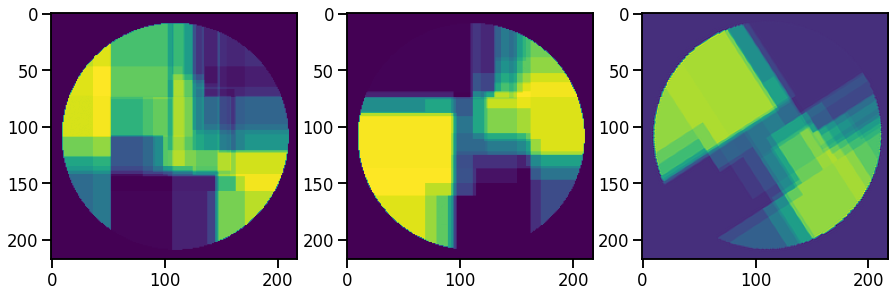

In [122]:
fig,axs = plt.subplots(1,3, figsize=(15,5))
axs[0].imshow(task1pred1_reshaped)
axs[1].imshow(task2pred2_reshaped)
axs[2].imshow(task1pred1_deformed)

(-1.0, 1.0)

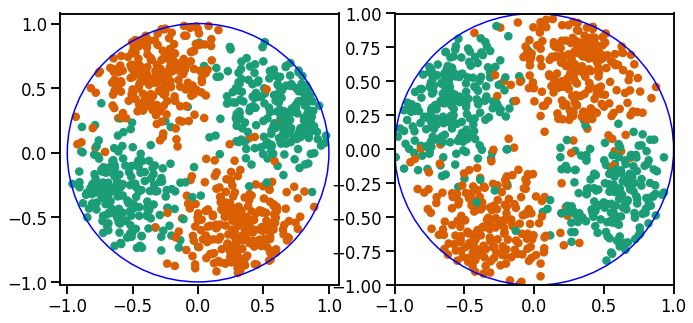

In [128]:
fig,axs = plt.subplots(1,2, figsize=(11,5))
colors = sns.color_palette("Dark2", n_colors=2)
ax = axs[0]
ax.scatter(test_task1[:,0], test_task1[:,1], c=get_colors(colors, test_label_task1), s=50)
circle = plt.Circle((0, 0), 1, color='b', fill=False)
ax.add_artist(circle)
plt.xlim([-1, 1])
plt.ylim([-1, 1])
ax = axs[1]
ax.scatter(test_task2[:,0], test_task2[:,1], c=get_colors(colors, test_label_task2), s=50)
circle = plt.Circle((0, 0), 1, color='b', fill=False)
ax.add_artist(circle)
plt.xlim([-1, 1])
plt.ylim([-1, 1])

In [200]:
params_to_mat(params)

array([[ 0.779501 ,  0.622343 , -0.0681927],
       [-0.637417 ,  0.794638 ,  1.21177  ],
       [ 0.       ,  0.       ,  1.       ]])

In [33]:
start_time = time.time()
print(exp(100,100,7))
print("--- %s seconds ---" % (time.time() - start_time))

[0.051 0.056 0.    0.    0.057 0.    0.   ]
--- 19.761927366256714 seconds ---


In [113]:
# start_time = time.time()
# errors_all = {}
rep = 3000
angle = 45
error45 = Parallel(n_jobs=-1, verbose=1)(
    delayed(exp)(
        100, 100, ceil(log2(100)), task2_angle=np.pi*(angle/180)
    ) for _ in range(rep)
)

# print("--- %s seconds ---" % (time.time() - start_time))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 25.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 58.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 105.3min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 165.6min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 238.0min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 323.6min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 398.2min finished


In [117]:
for i in [1,6]:
    print(np.mean(np.array(error45)[:2000,0]) / np.mean(np.array(error45)[:2000,i]))

0.8896756024336461
0.8920456059031941


In [43]:
errors_all = {}
errors_all["error45"] = error45

In [44]:
pickle_out = open("errors_all-sitk-lddmm-angles0_15_90-n_samples100.pickle", "wb")
pickle.dump(errors_all, pickle_out)
pickle_out.close()

In [45]:
pickle_in = open("errors_all-sitk-lddmm-angles0_15_90-n_samples100.pickle", "rb")
i = pickle.load(pickle_in)